<a href="https://colab.research.google.com/github/tatianamgar/Work_GPN/blob/main/ML%20input_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))
from NER.utilits.preprocessing import tokenize_and_preserve_labels
from transformers import DistilBertTokenizer


In [ ]:
train = pd.read_excel('../data/train_data10.xlsx', engine='openpyxl')
val = pd.read_excel('../data/val_data10.xlsx', engine='openpyxl')
test = pd.read_excel('../data/test_data10.xlsx', engine='openpyxl')

sents = pd.read_excel('../data/all_sentences10.xlsx', engine='openpyxl')

df = pd.read_excel('../data/all_data.xlsx', engine='openpyxl')

In [ ]:
df_gr = df.groupby('sentence').agg({'label': list})
train_gr = train.groupby('sentence').agg({'label': list})
val_gr = val.groupby('sentence').agg({'label': list})
test_gr = test.groupby('sentence').agg({'label': list})

In [ ]:
mlb = MultiLabelBinarizer()

In [ ]:
tags = mlb.fit_transform(df_gr['label'])
train_tags = mlb.transform(train_gr['label'])
val_tags = mlb.transform(val_gr['label'])
test_tags = mlb.transform(test_gr['label'])

In [ ]:
splt = pd.DataFrame({
    'label': mlb.classes_,
    'all': tags.sum(axis=0),
    'train': train_tags.sum(axis=0), 
    'val': val_tags.sum(axis=0),
    'test': test_tags.sum(axis=0)
})
splt

,label,all,train,val,test
0,B-Вид изделия,7359,5947,661,751
1,B-Наименование системы здания,2,2,0,0
2,B-Нормативный документ,3254,2616,306,332
3,B-Тип и подтип здания,3,3,0,0
4,B-Условный проход,4,4,0,0
...,...,...,...,...,...
168,I-цвет,866,701,78,87
169,I-цена деления шкалы,71,58,6,7
170,I-частота,127,103,11,13
171,"I-шаг резьбы, мм",8,6,1,1


In [ ]:
splt_tags = splt.copy()

In [ ]:
splt_tags['label'] = splt_tags['label'].apply(lambda x: x.replace('B-', '')).apply(lambda x: x.replace('I-', ''))

In [ ]:
splt_tags.groupby('label').sum().reset_index().to_excel('label_counts.xlsx', index=None)

In [ ]:
splt_percent = splt.copy()
splt_percent['all'] = splt_percent['all'].apply(lambda x: x / splt_percent['all'].sum())
splt_percent['train'] = splt_percent['train'].apply(lambda x: x / splt_percent['train'].sum())
splt_percent['val'] = splt_percent['val'].apply(lambda x: x / splt_percent['val'].sum())
splt_percent['test'] = splt_percent['test'].apply(lambda x: x / splt_percent['test'].sum())

In [ ]:
splt_plt = pd.DataFrame({'label': splt_percent['label'].tolist() * 4, 
              'value': splt_percent['all'].tolist() + splt_percent['train'].tolist() + splt_percent['val'].tolist() + splt_percent['test'].tolist(),
              'type': ['all']*len(splt_percent) + ['train']*len(splt_percent) + ['val']*len(splt_percent) + ['test']*len(splt_percent)
             })

In [ ]:
splt_percent.apply(lambda x: np.abs(x['all'] - x['train']) + np.abs(x['all'] - x['val']) + np.abs(x['all'] - x['test']), axis=1).mean()

0.00017892449969845957

In [ ]:
splt_plt.groupby('label').agg({'value': np.std}).mean()

value    0.000062
dtype: float64

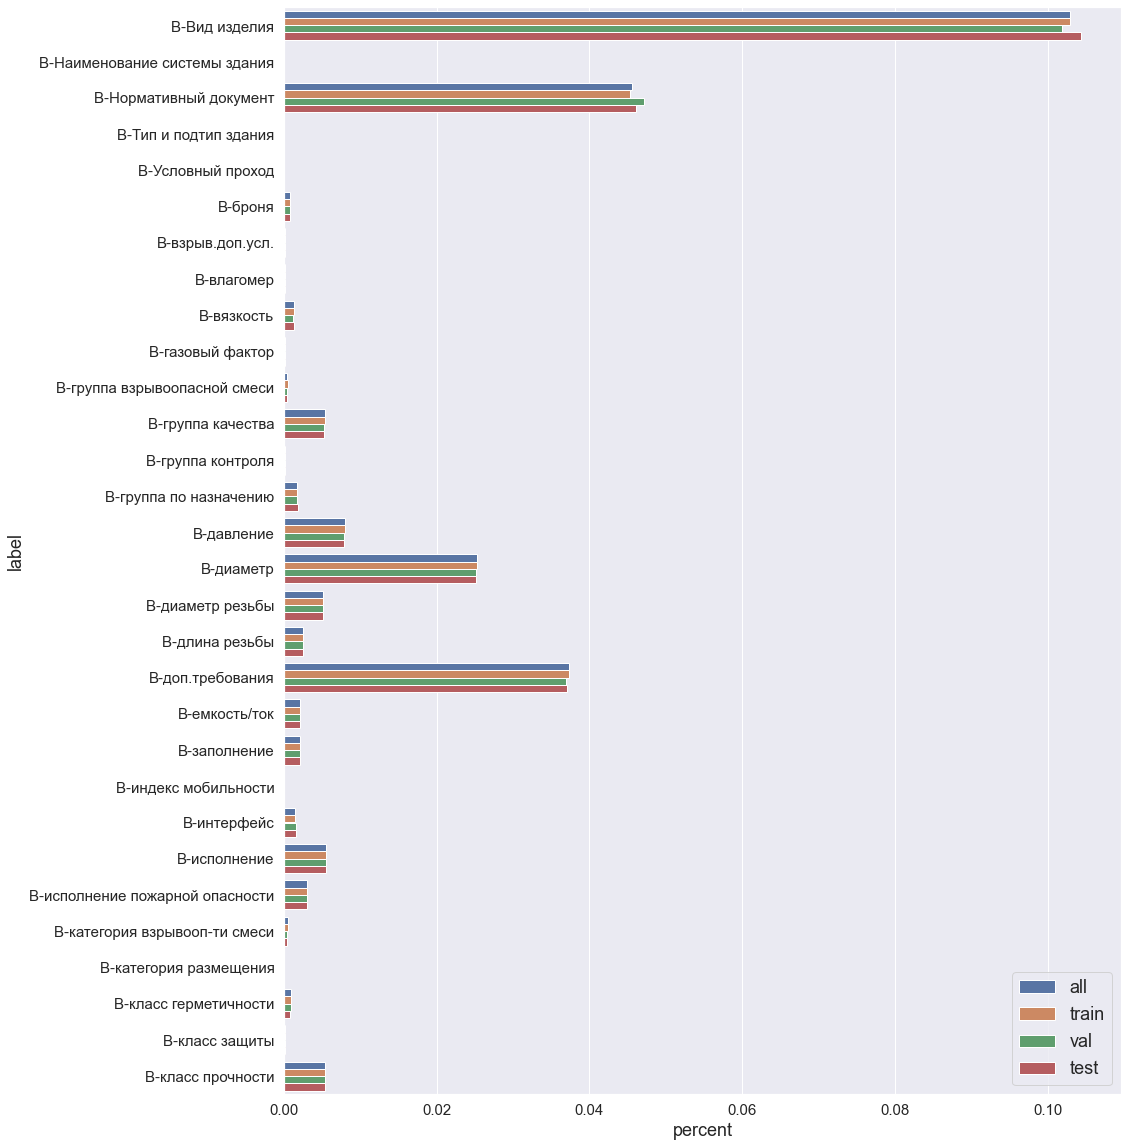

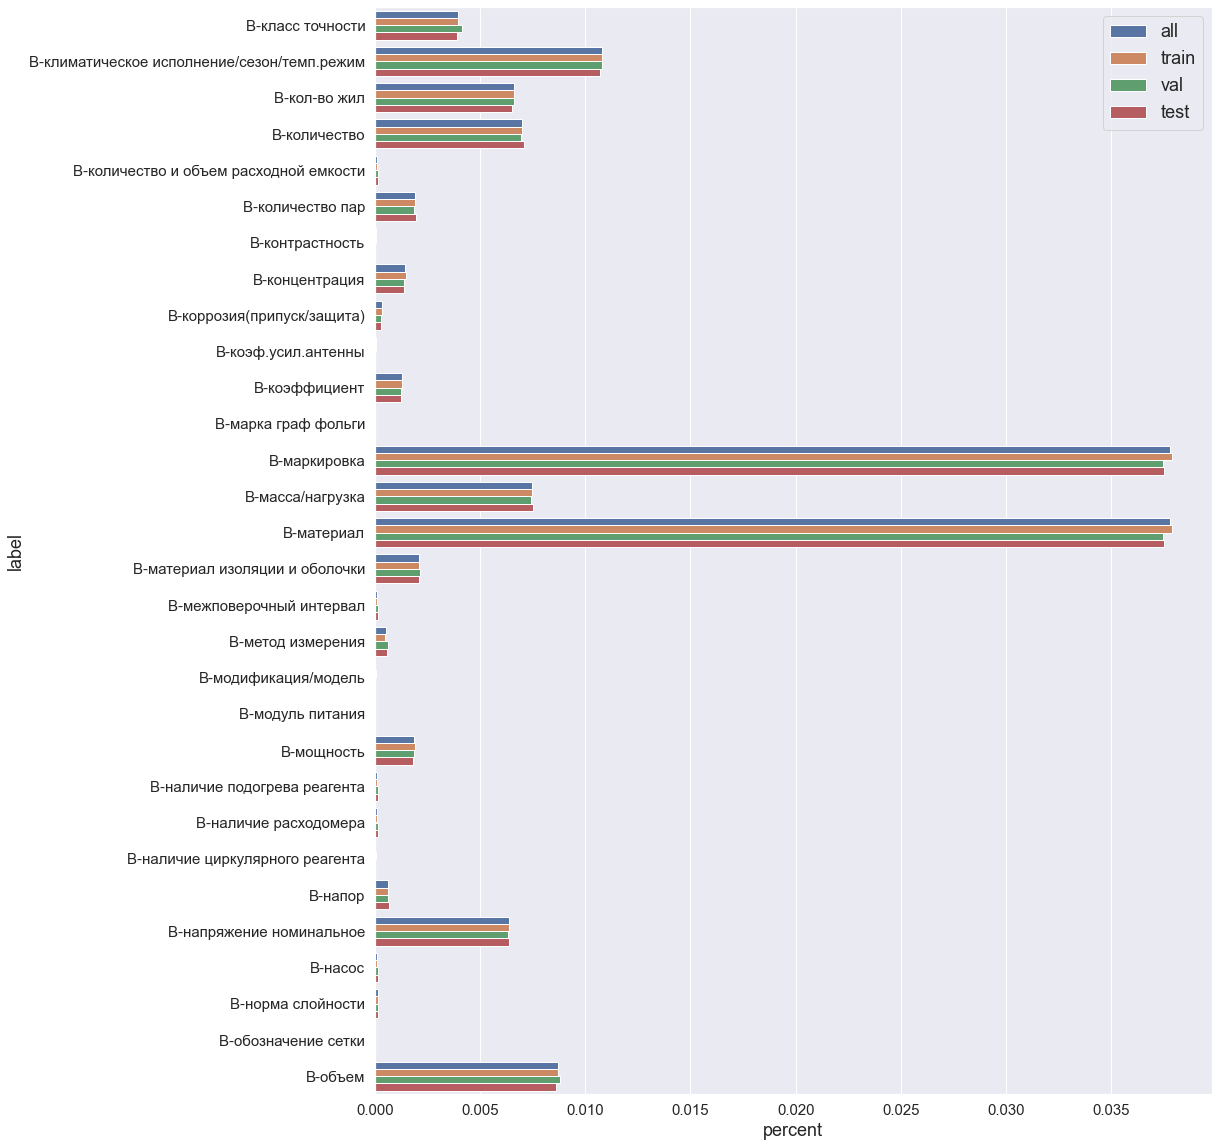

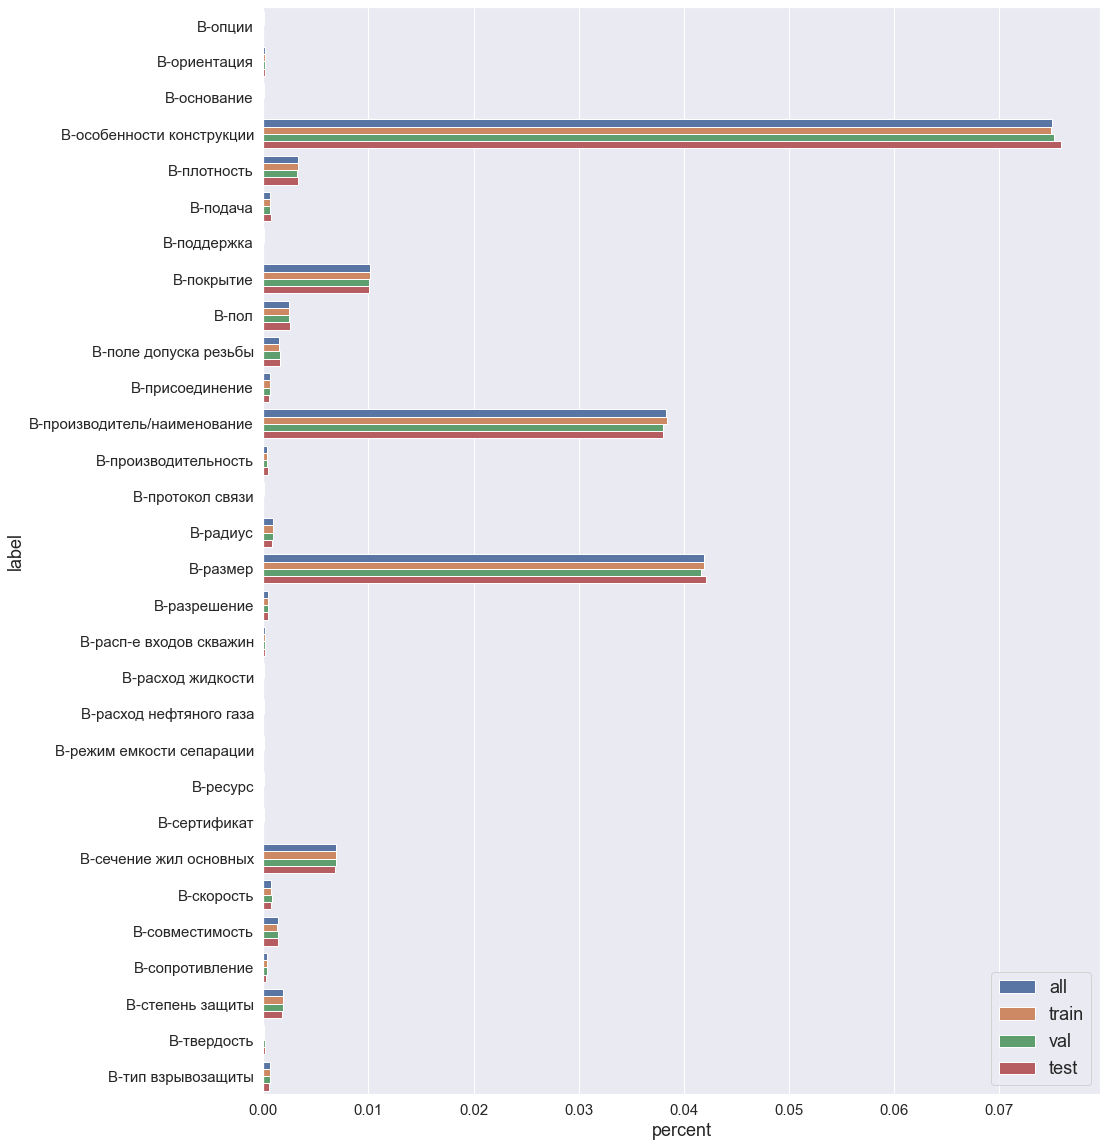

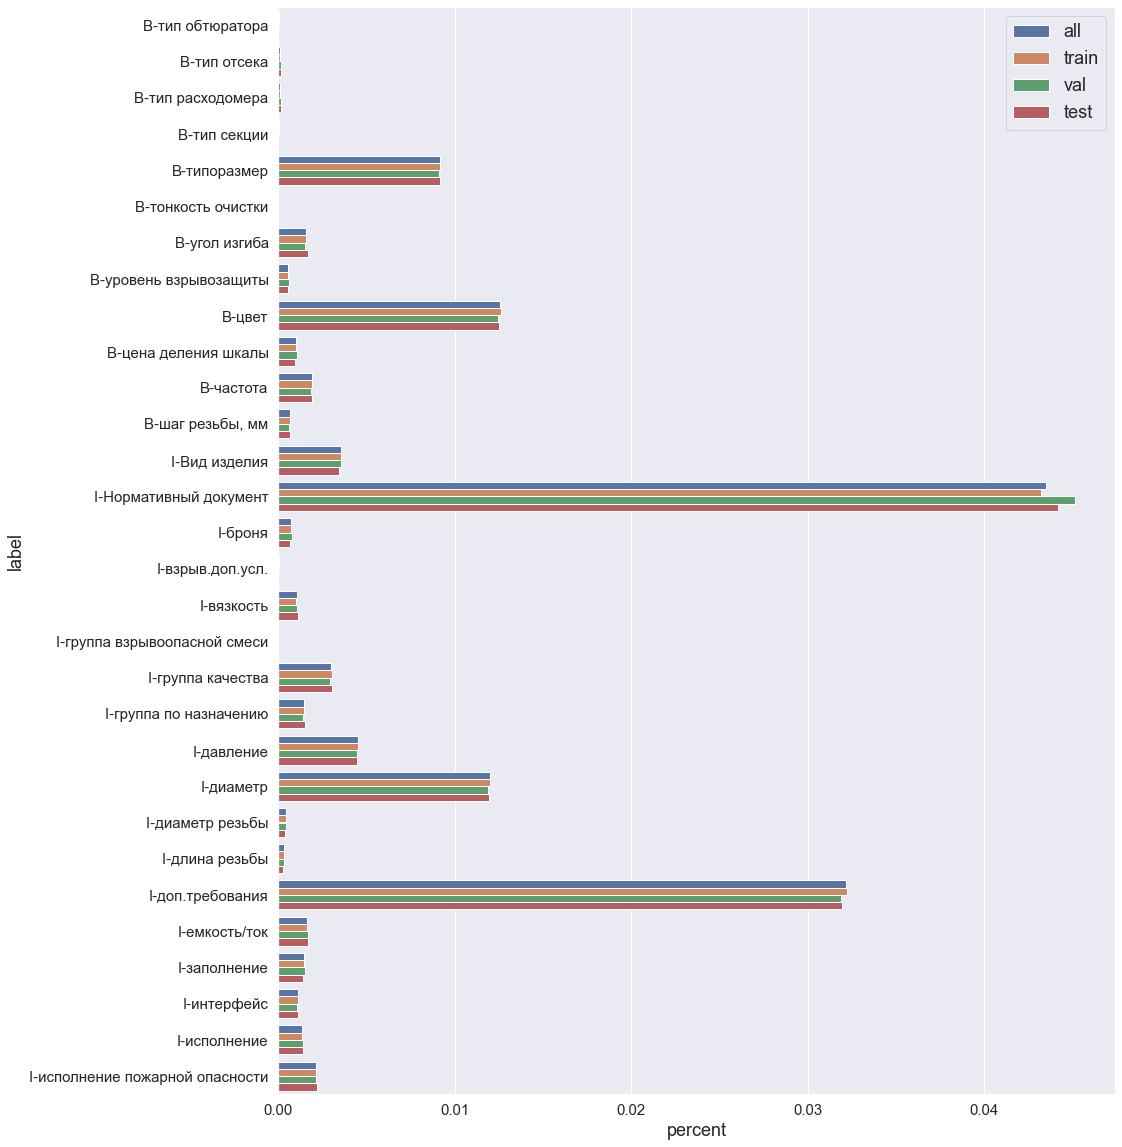

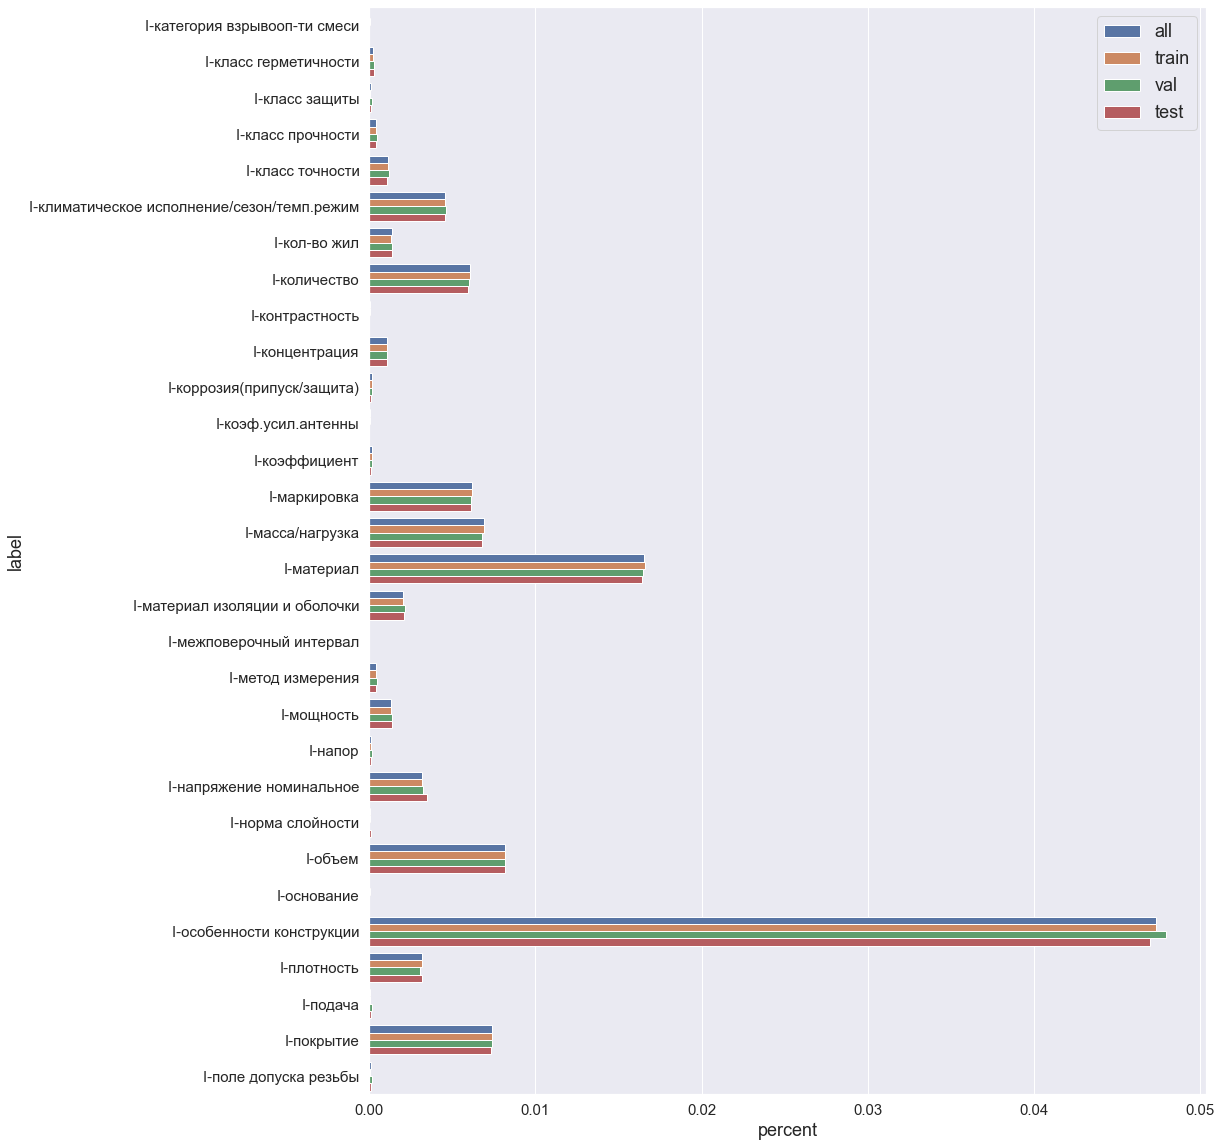

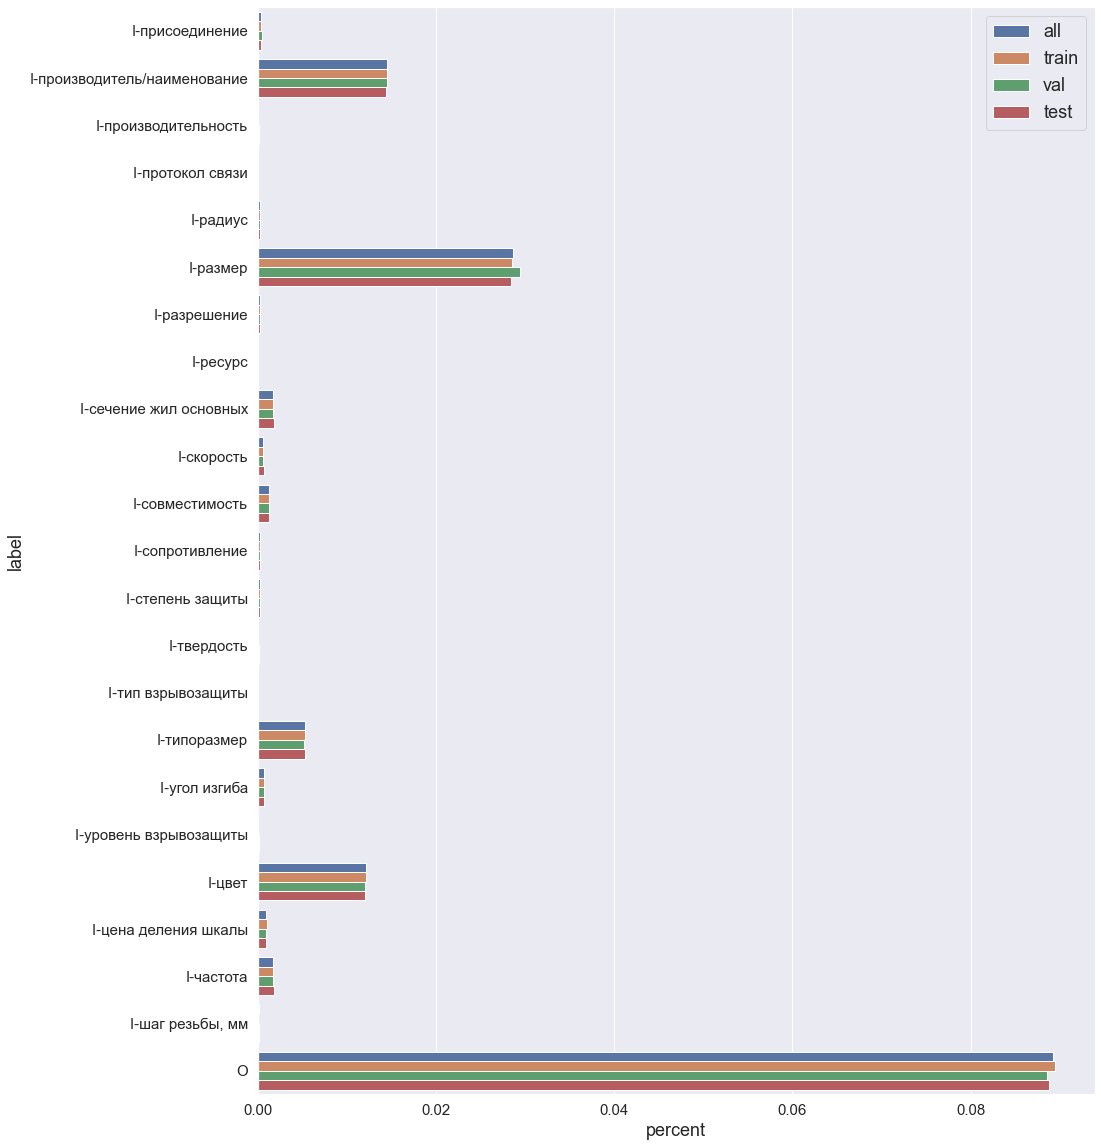

In [ ]:
for i in range(0, len(mlb.classes_), 30):
    plt.figure(figsize=(15, 20))
    sns.barplot(splt_plt[splt_plt['label'].isin(mlb.classes_[i:i+30])], x='value', y='label', hue='type')
    plt.ylabel('label', fontsize=18)
    plt.xlabel('percent', fontsize=18)
    plt.tick_params(axis='both', labelsize=15)
    plt.tick_params(axis='x', rotation=0)
    plt.legend(fontsize=18)
    plt.show()

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained(
        '../data/model_data/tokenizer', do_lower_case=False
    )

In [ ]:
res={}
for i in df['sentence'].unique():
    snt = df[df['sentence'] == i]
    res[i] = tokenize_and_preserve_labels(snt['word'], snt['label'], tokenizer)

In [ ]:
new_tags_df = pd.DataFrame(res).T.reset_index()
new_tags_df = new_tags_df.drop(columns=[0]).rename(columns={'index': 'sentence', 1: 'label'})

In [ ]:
x = [i for i in range(new_tags_df['label'].apply(lambda x: len(x)).max())]
y = [len(new_tags_df['label'].apply(lambda x: x[:i]).explode()) for i in x]
y_sent = [new_tags_df['label'].apply(lambda x: len(x) <= i).sum() for i in x]
y_tags = [len(new_tags_df['label'].apply(lambda x: x[:i]).explode().unique()) for i in x]

In [ ]:
MAX_LEN = 200
pd.DataFrame({'Tokens': [len(new_tags_df['label'].apply(lambda x: x[:MAX_LEN]).explode()) / len(new_tags_df['label'].explode())],
              'Full sentences': new_tags_df['label'].apply(lambda x: len(x) <= MAX_LEN).sum() / len(new_tags_df),
              'Tags': len(new_tags_df['label'].apply(lambda x: x[:MAX_LEN]).explode().unique()) / len(new_tags_df['label'].explode().unique())
             })

,Tokens,Full sentences,Tags
0,0.947785,0.967155,1.0


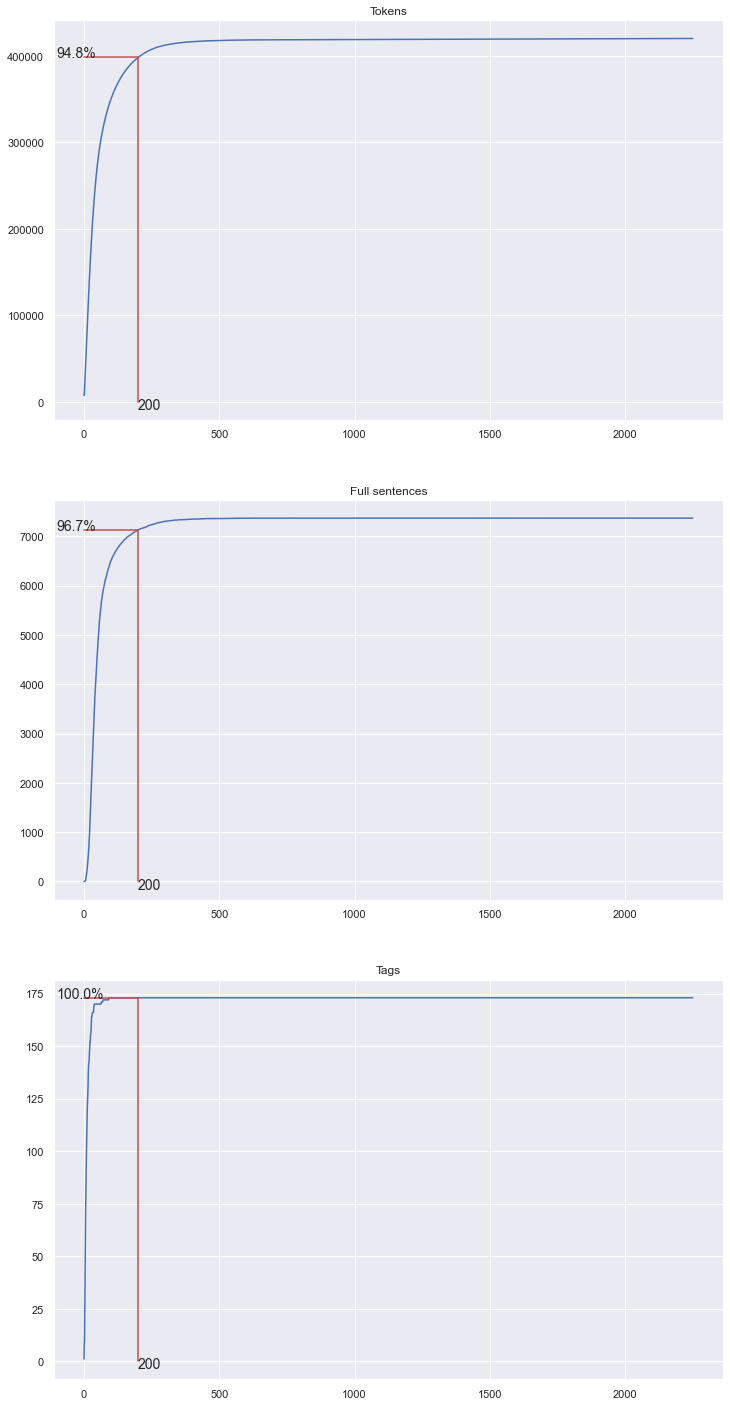

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 25))


y_tokens = len(new_tags_df['label'].apply(lambda x: x[:MAX_LEN]).explode())
pr_tokens = y_tokens / len(new_tags_df['label'].explode())

ax1.plot(x, y)
ax1.set_title('Tokens')
ax1.plot([0, MAX_LEN], [y_tokens, y_tokens], c='r')
ax1.plot([MAX_LEN, MAX_LEN], [0, y_tokens], c='r')
ax1.text(-np.max(x)*.045, y_tokens, '{:.1f}%'.format(pr_tokens*100), fontsize=14)
ax1.text(MAX_LEN, -np.max(y)*.02, f'{MAX_LEN}', fontsize=14)


y_fs = new_tags_df['label'].apply(lambda x: len(x) <= MAX_LEN).sum()
pr_fs = y_fs / len(new_tags_df)

ax2.plot(x, y_sent)
ax2.set_title('Full sentences')
ax2.plot([0, MAX_LEN], [y_fs, y_fs], c='r')
ax2.plot([MAX_LEN, MAX_LEN], [0, y_fs], c='r')
ax2.text(-np.max(x)*.045, y_fs, '{:.1f}%'.format(pr_fs*100), fontsize=14)
ax2.text(MAX_LEN, -np.max(y_sent)*.02, f'{MAX_LEN}', fontsize=14)

y_tg = len(new_tags_df['label'].apply(lambda x: x[:MAX_LEN]).explode().unique())
pr_tg = y_tg / len(new_tags_df['label'].explode().unique())

ax3.plot(x, y_tags)
ax3.set_title('Tags')
ax3.plot([0, MAX_LEN], [y_tg, y_tg], c='r')
ax3.plot([MAX_LEN, MAX_LEN], [0, y_tg], c='r')
ax3.text(-np.max(x)*.045, y_tg, '{:.1f}%'.format(pr_tg*100), fontsize=14)
ax3.text(MAX_LEN, -np.max(y_tags)*.02, f'{MAX_LEN}', fontsize=14)

plt.show()